In [ ]:
# using Pkg
# Pkg.build("PyCall")
# Pkg.add("PrettyTables")
##################################################################
### packages ###
##################################################################

using LinearAlgebra
using PyPlot
using PrettyTables

In [5]:
##################################################################
### global variables ###
##################################################################

"""
    Units of distance: angstrom
    Units of energy: eV
"""

# C-C distance
dCC = 1.42

# NN hopping (intralayer)
t1 = 2.7

# lattice vectors of AB BLG (same as graphene)
a1G = sqrt(3)*[1/2,sqrt(3)/2]*dCC
a2G = sqrt(3)*[-1/2,sqrt(3)/2]*dCC
## reciprocal lattice
b1G = 4*pi/3*[sqrt(3)/2,1/2]/dCC
b2G = 4*pi/3*[-sqrt(3)/2,1/2]/dCC

# Pauli matrices
sigma0 = [1 0; 0 1]
sigma1 = [0 1; 1 0]
sigma2 = [0 -im; im 0]
sigma3 = [1 0; 0 -1]

2×2 Matrix{Int64}:
 1   0
 0  -1

In [12]:

##################################################################
### functions ###
##################################################################

# AB BLG model with displacement field
"""
    intralayer: NN TB model (hopping t1)
    interlayer: hopping tperp between dimer sites, i.e., aligned
        A and B sites
    displacement field: +V0 for layer 1, -V0 for layer 2
"""
## f(k)
function f(k)
    return 1 + exp(im*dot(k,a1G)) + exp(im*dot(k,a2G))
end
## Hamiltonian
#=
    basis: (1,A), (1,B), (2,A), (2,B)     (layer,sublattice)
=#
function H_ABBLG_V0(k,tperp,V0)
    #AB BLG
    matrix = [
        0 -t1*f(k) 0 tperp;
        -t1*conj(f(k)) 0 0 0;
        0 0 0 -t1*f(k);
        tperp 0 -t1*conj(f(k)) 0;
        ]

    #V0
    matrix += V0*kron(sigma3,sigma0)

    return matrix
end

# SL potential in AB BLG
"""
    amplitude of potential: VSL
    ratio of potential between layers: alpha (layer 2 feels
        alpha*VSL)
"""
## off-diagonal matrix for folded Hamiltonian
#=
    basis: (1,A), (1,B), (2,A), (2,B)     (layer,sublattice)
=#
function T_SL(VSL,alpha)
    matrix = VSL/2*(kron(sigma0+sigma3,sigma0)
        + alpha*kron(sigma0-sigma3,sigma0))

    return matrix
end
## folded Hamiltonian
function H_folded(k,tperp,V0,VSL,alpha,Qvecs,Qn)
    dim = 4*length(Qvecs)
    matrix = zeros(ComplexF64,dim,dim)

    for it in 1:length(Qvecs)
        iti = (it-1)*4 + 1
        itf = it*4

        matrix[iti:itf,iti:itf] += H_ABBLG_V0(k+Qvecs[it],
            tperp,V0)

        for Q in Qn
            index = findfirst(v -> isapprox(v, Qvecs[it]+Q, atol=1e-6),Qvecs)

            if index!= nothing
                coli = (index-1)*4+1
                colf = index*4

                matrix[iti:itf,coli:colf] += T_SL(VSL,alpha)
            end
        end
    end

    return matrix
end

"""
Diagonalization of Hamiltonian (or any other hermitian matrix)

< Notes >
-------------------------------------------------------------------------------
- neigs
nr of eigenvalues to keep (default: size(H,1))
-------------------------------------------------------------------------------
"""
function eigensolver_H(H;neigs=size(H,1))
    # check if H is hermitian
    #=
    if ishermitian(H)!=true
        print("ERROR: H is not hermitian")
        return nothing,nothing
    end
    =#
    H_hermitian = (H + H')/2
    if isapprox(H,H_hermitian) != true
        print("ERROR: H is not hermitian")
        return nothing,nothing
    end

    # diagonalization (ordered by smallest eigenvalue)
    En,psin = eigen(Hermitian(Matrix(H)),1:neigs)

    return En,psin
end

"""
Calculates energy bands of H2D(kx,ky) (2D Bloch Hamiltonian) along kpath
"""
function En_kpath_2D(H2D,kpath;nbands=size(H2D(0,0),1))
    # energy bands
    En_kpath = Matrix{Float64}(undef,size(kpath,1),nbands)
    for itk in 1:size(kpath,1)
        kx = kpath[itk][1]
        ky = kpath[itk][2]

        H = H2D(kx,ky)

        En,_ = eigensolver_H(H,neigs=nbands)

        En_kpath[itk,:] = En
    end

    return En_kpath
end

"""
Plot of energy bands

< Notes >
-------------------------------------------------------------------------------
- pathticks
to have xticks, take pathticks = (pathtickpos,pathticklabels), where
    pathticklabels is list of labels of phi points, and pathtickpos the
    corresponding positions in phipath
-------------------------------------------------------------------------------
"""
function Ebands(En_phipath;linewidth=2,
    linecolor="auto",
    ylims="auto",
    imgsize=(6,6),
    pathticks=([],[]),
    EF=0,
    save=false,fig_dir_name="/Users/scgo/Downloads/p")

    # EF
    if EF!=0
        En_phipath -= EF*ones(size(En_phipath))
    end

    # main plot
    figure(figsize=imgsize)
    if linecolor=="auto"
        for it in 1:size(En_phipath,2)
            plot(1:size(En_phipath,1), En_phipath[:,it], linewidth=linewidth)
        end
    else
        for it in 1:size(En_phipath,2)
            plot(1:size(En_phipath,1), En_phipath[:,it], linewidth=linewidth,
                    c=linecolor)
        end
    end
    xlabel("k-path")
    ylabel("Energy")
    if ylims != "auto"
        ylim(ymin=ylims[1],ymax=ylims[2])
    end
    xticks(pathticks[1],pathticks[2])

    # save figure
    if save==true
        savefig(fig_dir_name*".svg")
    end

    gcf()  # Gets the current figure
    display(gcf())  # Displays the figure
    # show figure
    # show()

    return
end

##################################################################
### CHATGPT functions ###
##################################################################

# Function to calculate reciprocal lattice vectors
function reciprocal_vectors(a1, a2)
    # Compute the area of the parallelogram (scalar) formed by a1 and a2
    A = a1[1] * a2[2] - a1[2] * a2[1]  # Determinant for 2D cross product

    # Reciprocal lattice vectors
    b1 = 2 * pi / A * [a2[2], -a2[1]]   # b1 is perpendicular to a2
    b2 = 2 * pi / A * [-a1[2], a1[1]]   # b2 is perpendicular to a1

    return b1, b2
end

# Function to check if a vector Q is in the lattice spanned by b1G and b2G,
# and if it's related to any vector in the list Qvecs through integer combinations.
function is_in_GG_lattice(Q, Qvecs)
    # Create a matrix B from the basis vectors b1G and b2G
    B = hcat(b1G, b2G)  # Concatenate b1G and b2G as columns

    # Initialize a counter to track how many Qvecs relate to Q
    is_Q_in_lattice = 0

    # Loop through each vector in Qvecs
    for Qvec in Qvecs
        # Calculate the difference between Q and the current vector Qvec
        Qdiff = Q - Qvec

        # Solve for coefficients that express Qdiff as an integer combination of b1G and b2G
        coeffs = B \ Qdiff

        # Check if all coefficients are close to integers (within tolerance)
        is_Q_in_lattice += all(abs(x - round(x)) < 1e-6 for x in coeffs)
    end

    # If at least one Qvec relates to Q, return true
    if is_Q_in_lattice > 0
        return true
    else
        return false
    end
end

# This function generates a list of vectors Q = m1 * b1 + m2 * b2 in a concentric pattern.
# The vectors are generated by varying m1 and m2, where m1 and m2 are integers.
# The magnitude of each vector increases systematically up to a given maximum value.
# The goal is to generate vectors that spread out concentrically around the origin.
# The maximum value is either provided (max_val) or set such that all new vectors are
#   related to previous ones by vectors of reciprocal lattice GG.
function generate_concentric_vectors_inG(b1, b2; max_val=typemax(Int))
    # Initialize an empty array to store the generated vectors
    vectors = []

    # Loop over the "sum" of m1 and m2. This ensures concentric generation.
    # We loop up to `max_val` to ensure that the magnitude of the vectors grows systematically.
    for m_sum in 0:max_val
        stop = 0  # Counter to track whether any new vectors were added

        # Loop over possible values of m1 in the range [-m_sum, m_sum]
        for m1 in -m_sum:m_sum
            # Calculate m2 based on the current m_sum and m1
            m2 = m_sum - abs(m1)

            # Calculate the vector Q using the current m1 and m2
            Q = m1 * b1 + m2 * b2

            # Check if the vector Q is in the lattice defined by previous vectors
            if is_in_GG_lattice(Q, vectors) == false
                # Add the vector Q = m1 * b1 + m2 * b2 to the list
                push!(vectors, Q)

                stop += 1  # Increment the counter since a new vector was added
            end

            # If m2 is not zero, calculate the vector Q2 = m1 * b1 - m2 * b2
            # This part ensures we also get vectors in the opposite direction (-m2),
            # spreading the vectors symmetrically around the origin.
            if m2 != 0
                Q2 = m1 * b1 - m2 * b2  # Change the sign of m2 to get the opposite direction

                # Check if Q2 is in the lattice. If not, add it to the list of vectors
                if is_in_GG_lattice(Q2, vectors) == false
                    push!(vectors, Q2)

                    stop += 1  # Increment the counter since a new vector was added
                end
            end
        end

        # If no new vectors were added during this iteration, exit the loop
        if stop == 0
            return vectors  # Return the list of generated vectors
        end
    end

    # Return the list of generated vectors after the loop ends
    return vectors
end

# Function to calculate Euclidean distance between two points
function distance(p1, p2)
    return norm(p2 - p1)
end

# Interpolation function with proportional number of points based on distance
function interpolate_path(points; total_points=100)
    # Calculate distances between consecutive points
    distances = [distance(points[i], points[i + 1]) for i in 1:length(points)-1]

    # Total distance of the path
    total_distance = sum(distances)

    # Allocate points for each segment based on its proportion of the total distance
    path = []
    indices = Int[]  # Initialize an empty array for segment start indices
    current_index = 1  # Initialize the starting index

    for i in 1:(length(points) - 1)
        segment_distance = distances[i]
        segment_points = round(Int, total_points * (segment_distance / total_distance))

        # Store the current index for this segment
        push!(indices, current_index)

        # Interpolate points between current and next vector
        for t in 0:1/(segment_points-1):1
            push!(path, points[i] * (1 - t) + points[i + 1] * t)
        end

        # Update the current index for the next segment
        current_index += segment_points
    end

    return path, indices
end

function decompose_and_keep_remainder(P, b1, b2)
    # Create a matrix B using b1 and b2 as columns
    B = hcat(b1, b2)

    # Solve for m1 and m2 (not necessarily integers)
    coeffs = B \ P

    # Round m1 and m2 to the nearest integers
    m1 = round(Int, coeffs[1])
    m2 = round(Int, coeffs[2])

    # Compute the remainder (rest) by subtracting the integer combination of b1 and b2 from P
    rest = P - (m1 * b1 + m2 * b2)

    # Return only the remainder
    return rest
end

# Function to rotate a 2D vector v by multiples of 60 degrees
function rotate_vector_60deg(v)
    # Initialize an empty array to store the rotated vectors
    rotated_vectors = []

    # Define the 60-degree rotation matrix
    θ = π / 3  # 60 degrees in radians
    R60 = [cos(θ) -sin(θ); sin(θ) cos(θ)]

    # Start with the original vector
    current_v = v

    # Push the original vector and its 5 rotations to the list
    for i in 1:6
        push!(rotated_vectors, current_v)

        # Rotate the vector by 60 degrees for the next iteration
        current_v = R60 * current_v
    end

    return rotated_vectors
end


rotate_vector_60deg (generic function with 1 method)

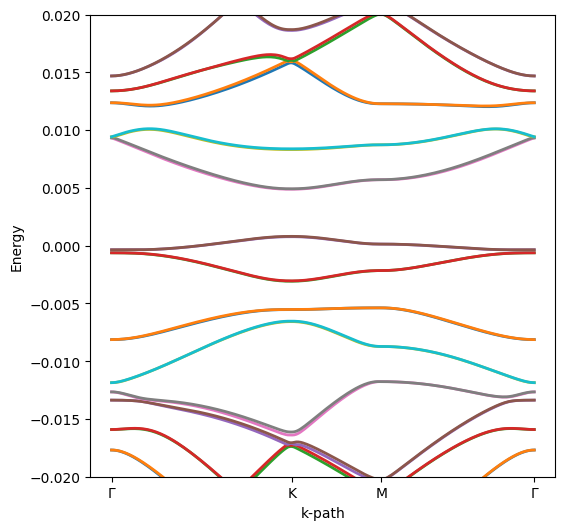

In [13]:
# parameters
L = 500
tperp = 0.4
V0 = 0
VSL = 0.005
alpha = 0.3

#b1 = 2*pi/L*[sqrt(3)/2,1/2]
#b2 = 2*pi/L*[-sqrt(3)/2,1/2]
b1 = b1G/floor(2*L/3/dCC)
b2 = b2G/floor(2*L/3/dCC)
Gamma = [0.0,0.0]
M = b1/2
K = (b1-b2)/3

Qn = rotate_vector_60deg(b1)

Qvecs = generate_concentric_vectors_inG(b1, b2,max_val=4)

KG = (b1G-b2G)/3
KpG = -KG
H2D_KG(kx,ky) = H_folded([kx,ky]+KG,tperp,V0,VSL,alpha,Qvecs,Qn)
H2D_KpG(kx,ky) = H_folded([kx,ky]+KpG,tperp,V0,VSL,alpha,Qvecs,Qn)

K_new = decompose_and_keep_remainder(KG, b1, b2)
# K_new = [0,0]
#print(K_new)
Kp_new = -K_new

path_points_K = [Gamma-K_new, K-K_new, M-K_new, Gamma-K_new]
kpath_K,indices = interpolate_path(path_points_K, total_points=200)
path_points_Kp = [Gamma-Kp_new, K-Kp_new, M-Kp_new, Gamma-Kp_new]
kpath_Kp,indices = interpolate_path(path_points_Kp, total_points=200)
pathtickpos = push!(indices,length(kpath_Kp))
pathticklabels = ["Γ","K","M","Γ"]
pathticks = (pathtickpos,pathticklabels)

En_kpath_K = En_kpath_2D(H2D_KG,kpath_K)
En_kpath_Kp = En_kpath_2D(H2D_KpG,kpath_Kp)
En_kpath = hcat(En_kpath_K,En_kpath_Kp)
En_kpath_sorted = mapslices(sort, En_kpath; dims=2)
Ebands(En_kpath_sorted,pathticks=pathticks,ylims=[-0.02,0.02])